## 뷰메진 Assignment Test
### 컴퓨터비전 엔지니어 지원자: 정대현

**핵심 요소**
1. Segmentation backbone network에 대한 이해
2. Pipeline 구축
   data loader → train/validation → test(+evaluation)
3. 문제 해결 능력
4. GitHub을 이용한 코드 관리

**추가 요소**
1. 코딩 스타일
    1. Class
    2. Module
2. 창의적 아이디어
    1. crack segmentation : 오픈 소스 분할 모델 수정하여 crack 검출 성능을 높이기 위한 아이디어
    2. crack measurement : crack 길이와 폭을 측정하는 방법에 대한 아이디어
    3. augmentation : 학습 성능을 높이기 위해 다양한 아이디어

**[Requirements]**
1) Backbone network 모델 구성  
2) OpenCV와 Augmentation을 이용한 Augmentation  
3) Evaluation metric mIoU, ifwIoU(?)  
4) Crack measurement 함수/모듈  
5) 인프런스시 crack mask(png), crack width(number of pixels), crack length(number of pixels) 출력 확인하기

### 0. 라이브러리 호출 & 데이터 경로 지정하기

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import random, tqdm
import os, cv2
import math
from glob import glob
#import gc
#gc.enable()
import warnings
warnings.filterwarnings("ignore")
import albumentations as album
#imshow을 사용할때 커널이 죽을 경우 사용
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [ ]:
"""
#코랩연결용
!pip install segmentation_models_pytorch

from google.colab import drive
drive.mount('/content/drive')
DATA_DIR = '../content/drive/MyDrive/Colab Notebooks/mini_crack_segmentation_dataset/'
"""

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import segmentation_models_pytorch as smp
from segmentation_models_pytorch import utils

segmentation_models_pytorch documents  
https://smp.readthedocs.io/en/latest/index.html

In [ ]:
DATA_DIR = './mini_crack_segmentation_dataset/'

x_train_dir = os.path.join(DATA_DIR, 'train/input')
y_train_dir = os.path.join(DATA_DIR, 'train/output')

x_valid_dir = os.path.join(DATA_DIR, 'val/input')
y_valid_dir = os.path.join(DATA_DIR, 'val/output')

x_test_dir = os.path.join(DATA_DIR, 'test/input')
y_test_dir = os.path.join(DATA_DIR, 'test/output')

In [ ]:
#배경은 검은색, 크랙은 흰색 (RGB기준)
class_names = ['background', 'crack']
class_rgb_values = [[0, 0, 0], [255, 255, 255]]

print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

Class Names:  ['background', 'crack']
Class RGB values:  [[0, 0, 0], [255, 255, 255]]


### 1. 시각화 함수 설정

In [ ]:
def visualize(**images):
    #이미지는 한줄에 표시
    n_images = len(images)
    plt.figure(figsize=(20,8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]); 
        plt.yticks([])
        plt.title(name.replace('_',' ').title(), fontsize=20)
        plt.imshow(image)
    plt.show()

#이미지를 반전해서 보기 위한 one_hot_encode 추가
def one_hot_encode(label, label_values):
    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)
    return semantic_map
    
def reverse_one_hot(image):
    x = np.argmax(image, axis = -1)
    return x

def colour_code_segmentation(image, label_values):
    colour_codes = np.array(label_values)
    x = colour_codes[image.astype(int)]
    return x

OpenCV를 이용한 랜덤크롭과 회전 함수  
1. RandomCrop : OpenCV 기반 직접 작성, 50% 확률로 수행  
2. Rotate : OpenCV 기반 직접 작성, 25% 확률로 수행  

In [ ]:
def RandomCrop_Rotate(image, height=224, width=224):
    #랜덤크롭하기(50%)
    num = random.choices(range(0, 2), weights=[1,1])
    if num == 0:
        max_x = image.shape[1] - width
        max_y = image.shape[0] - height
        x = np.random.randint(0, max_x)
        y = np.random.randint(0, max_y)
        image = image[y: y + height, x: x + width]
    
    #회전하기(25%)
    num = random.choices(range(0, 4), weights=[1,1,1,1])
    if num == 0:
        image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    return image

### 2. 크랙 데이터셋 정의

In [ ]:
class crackDataset(torch.utils.data.Dataset):
    """
    이미지 읽기, 확대 적용 및 변환 전처리
    images_dir (str): 이미지 폴더 경로
    masks_dir (str): 분할 마스크 폴더 경로
    class_rgb_values (list): 분할 마스크 확대(확대)에서 추출할 선택한 클래스의 RGB 값
    data transfromation pipeline(e.g. 반전, 스케일 처리 등)
    preprocessing (albumentations.Compose): data preprocessing(e.g. 정규화, 형상 조작, etc.)
    """
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            class_rgb_values=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        #경로는 여기서 한번에 불러오기
        self.image_paths = [os.path.join(images_dir, image_id) for image_id in sorted(os.listdir(images_dir))]
        self.mask_paths = [os.path.join(masks_dir, image_id) for image_id in sorted(os.listdir(masks_dir))]
        self.class_rgb_values = class_rgb_values
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        # 이미지와 마스크 읽어오기
        image = cv2.cvtColor(cv2.imread(self.image_paths[i]), cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(cv2.imread(self.mask_paths[i]), cv2.COLOR_BGR2RGB)
        # one-hot-encode the mask
        mask = one_hot_encode(mask, self.class_rgb_values).astype('float')
        
        # 변환 적용
        if self.augmentation:
            image = RandomCrop_Rotate(image)
            mask = RandomCrop_Rotate(mask)
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # 전처리 적용
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        #이미지와 마스크 반환

    def __len__(self):
        # 길이 반환
        return len(self.image_paths)

해당 커스텀 데이터 셋을 통해서 이미지 확인

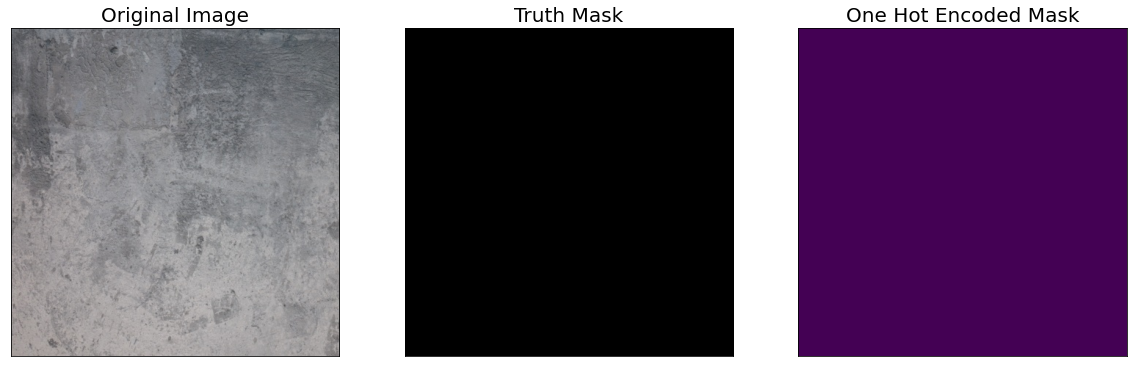

In [ ]:
dataset = crackDataset(x_train_dir, y_train_dir, class_rgb_values=class_rgb_values)
random_idx = random.randint(0, len(dataset)-1)
image, mask = dataset[random_idx]

visualize(
    original_image = image,
    truth_mask = colour_code_segmentation(reverse_one_hot(mask), class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)

### 3. 이미지 augmentation 함수 정의

훈련데이터와 검증데이터의 augmentation정의하기

In [ ]:
def get_training_augmentation():
    train_transform = [
        album.Compose([
                album.HorizontalFlip(p=1),
                album.RandomBrightnessContrast(p=1),
                album.RandomRain(p=1),
            ])
    ]
    return album.Compose(train_transform)

def get_validation_augmentation():
    test_transform = [
        album.PadIfNeeded(min_height=448, min_width=448, always_apply=True, border_mode=0),
    ]
    return album.Compose(test_transform)

def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

def get_preprocessing(preprocessing_fn=None):
    _transform = []
    if preprocessing_fn:
        _transform.append(album.Lambda(image=preprocessing_fn))
    _transform.append(album.Lambda(image=to_tensor, mask=to_tensor))
    return album.Compose(_transform)

정의한 이미지 augmentation 시각화하기

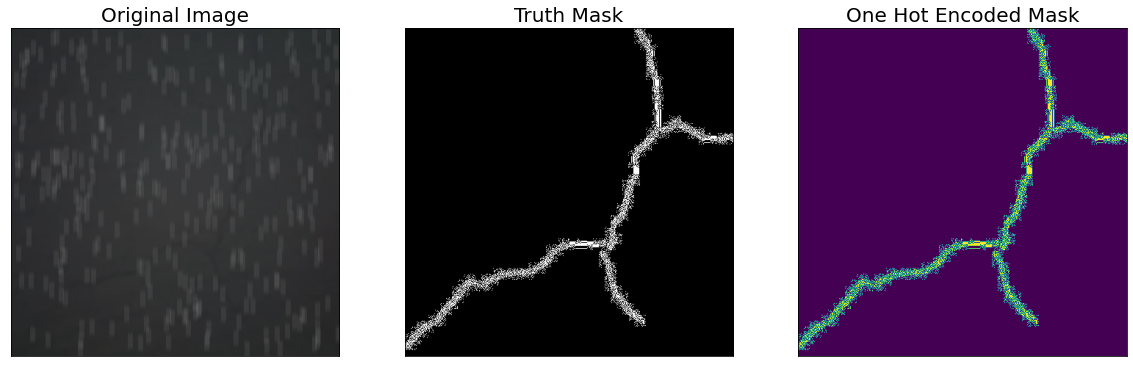

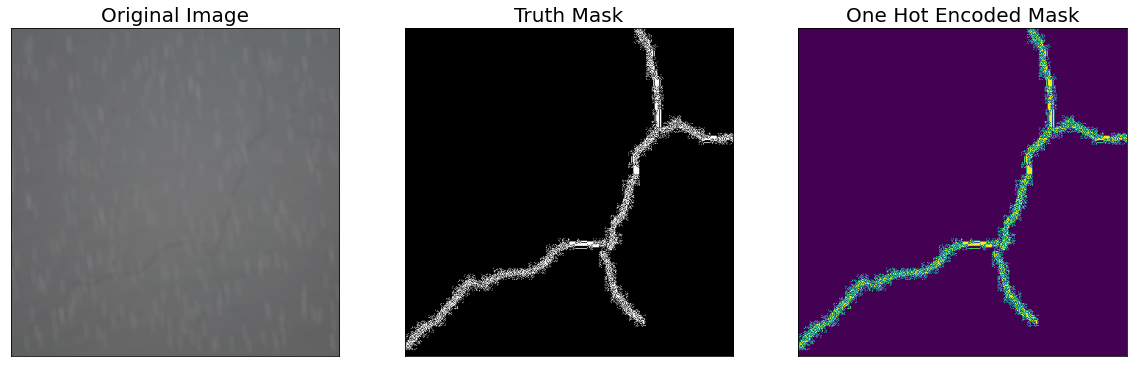

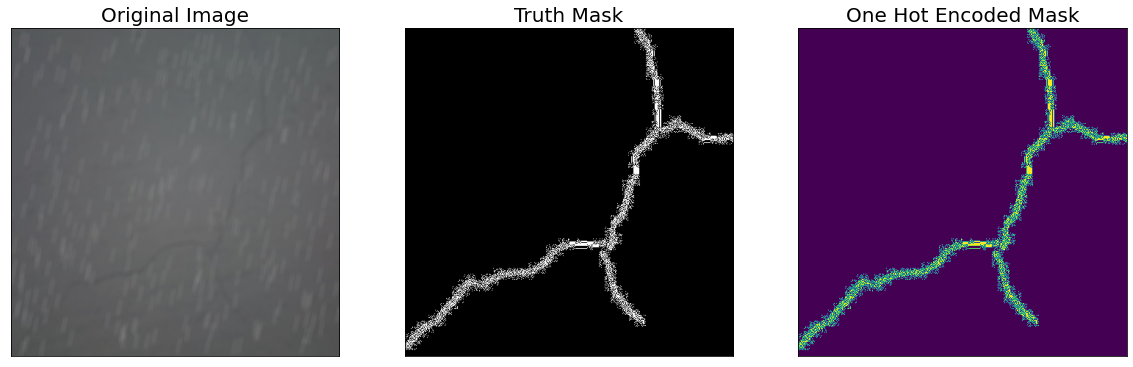

In [ ]:
augmented_dataset = crackDataset(
    x_train_dir, y_train_dir, 
    augmentation=get_training_augmentation(),
    class_rgb_values=class_rgb_values,
)

#이전과 같이 랜덤하게 인덱스 하나 뽑아오기
random_idx = random.randint(0, len(augmented_dataset)-1)

# 랜덤 이미지/마스크 쌍에 대한 증강
for i in range(3):
    image, mask = augmented_dataset[random_idx]
    visualize(
        original_image = image,
        truth_mask = colour_code_segmentation(reverse_one_hot(mask), class_rgb_values),
        one_hot_encoded_mask = reverse_one_hot(mask)
    )

### 4. 모델 정의 resnet101 + FPN

model: UnetPlusPlus, FPN, MNet, DeepLabV3Plus
ENCODER: resnet51, resnet101, resnet152, VGG, 

In [ ]:
ENCODER = 'resnet101'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = class_names
ACTIVATION = 'sigmoid'

model = smp.FPN(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)
#preprocessing_fn = None

데이터 불러오기

In [ ]:
train_dataset = crackDataset(
    x_train_dir, y_train_dir, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=class_rgb_values,
)
valid_dataset = crackDataset(
    x_valid_dir, y_valid_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=class_rgb_values,
)

# 데이터로더
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False)

하이퍼파라미터 셋팅

In [ ]:
TRAINING = True
EPOCHS = 10
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]
optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=1, T_mult=2, eta_min=5e-5,
)
if os.path.exists('../deeplabv3-efficientnetb4-frontend-using-pytorch/best_model.pth'):
    model = torch.load('../deeplabv3-efficientnetb4-frontend-using-pytorch/best_model.pth', map_location=DEVICE)

In [ ]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)
valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

학습 시작

In [ ]:
%%time
if TRAINING:
    best_iou_score = 0.0
    train_logs_list, valid_logs_list = [], []
    for i in range(0, EPOCHS):
        # Perform training & validation
        print('\nEpoch: {}'.format(i))
        train_logs = train_epoch.run(train_loader)
        valid_logs = valid_epoch.run(valid_loader)
        train_logs_list.append(train_logs)
        valid_logs_list.append(valid_logs)
        # Save model if a better val IoU score is obtained
        if best_iou_score < valid_logs['iou_score']:
            best_iou_score = valid_logs['iou_score']
            torch.save(model, './best_model.pth')
            print('Model saved!')


Epoch: 0
valid: 100%|██████████| 63/63 [04:51<00:00,  4.63s/it, dice_loss - 0.03119, iou_score - 0.9403]
Model saved!

Epoch: 1
valid: 100%|██████████| 63/63 [00:28<00:00,  2.18it/s, dice_loss - 0.03118, iou_score - 0.9403]

Epoch: 2
valid: 100%|██████████| 63/63 [00:29<00:00,  2.17it/s, dice_loss - 0.03118, iou_score - 0.9403]

Epoch: 3
valid: 100%|██████████| 63/63 [00:28<00:00,  2.19it/s, dice_loss - 0.03118, iou_score - 0.9403]

Epoch: 4
valid: 100%|██████████| 63/63 [00:28<00:00,  2.19it/s, dice_loss - 0.03118, iou_score - 0.9403]

Epoch: 5
valid: 100%|██████████| 63/63 [00:28<00:00,  2.21it/s, dice_loss - 0.03118, iou_score - 0.9403]

Epoch: 6
valid: 100%|██████████| 63/63 [00:28<00:00,  2.22it/s, dice_loss - 0.03118, iou_score - 0.9403]

Epoch: 7
valid: 100%|██████████| 63/63 [00:28<00:00,  2.23it/s, dice_loss - 0.03118, iou_score - 0.9403]

Epoch: 8
valid: 100%|██████████| 63/63 [00:28<00:00,  2.22it/s, dice_loss - 0.03118, iou_score - 0.9403]

Epoch: 9
valid: 100%|██████████|

### 5. 저장된 모델 불러오기

In [ ]:
# 저장한 모델 체크 포인트 불러오기
if os.path.exists('./best_model.pth'):
    best_model = torch.load('./best_model.pth', map_location=DEVICE)
    print('Loaded DeepLabV3+ model from this run.')
# 이전 커밋에서 이미 존재하는 경우
elif os.path.exists('../input//deeplabv3-efficientnetb4-frontend-using-pytorch/best_model.pth'):
    best_model = torch.load('../input//deeplabv3-efficientnetb4-frontend-using-pytorch/best_model.pth', map_location=DEVICE)
    print('Loaded DeepLabV3+ model from a previous commit.')

In [ ]:
# 테스트 데이터 전처리와 dataloader 생성
test_dataset = crackDataset(
    x_test_dir, 
    y_test_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=class_rgb_values,
)
test_dataloader = DataLoader(test_dataset)

test_dataset_vis = crackDataset(
    x_test_dir, y_test_dir, 
    augmentation=get_validation_augmentation(),
    class_rgb_values=class_rgb_values,
)

# 테스트 데이터 랜덤하게 불러와서 확인
random_idx = random.randint(0, len(test_dataset_vis)-1)
image, mask = test_dataset_vis[random_idx]

visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)

In [ ]:
# 크롭한 이미지를 원본 차원과 맞추기 위한 함수
def crop_image(image, target_image_dims=[1500,1500,3]):
    target_size = target_image_dims[0]
    image_size = len(image)
    padding = (image_size - target_size) // 2
    return image[
        padding:image_size - padding,
        padding:image_size - padding,
        :,
    ]

In [ ]:
#추론된 이미지 저장할 경로 생성
sample_preds_folder = 'sample_predictions/'
if not os.path.exists(sample_preds_folder):
    os.makedirs(sample_preds_folder)

#### Crack measurement 함수, metric 정의

In [ ]:
def Crack_measurement(mask):
    coordinates = np.nonzero(mask)
    x_coordinates = coordinates[0]
    y_coordinates = coordinates[1]
    x_min, x_max = np.min(x_coordinates), np.max(x_coordinates)
    y_min, y_max = np.min(y_coordinates), np.max(y_coordinates)
    width = x_max-x_min
    lenght = y_max-y_min
    return width, lenght

def metric(mask,pred):
    tp, fp, fn, tn = smp.metrics.get_stats(mask, pred, mode='binary', threshold=0.5)
    ifwIoU_value = ((1/(tp+fn))*(tp/((tp+fn)+(tp+fp)-tp))+(1/(tn+fp))*(tn/((tn+fp)+(tn+fn)-tn)))/((1/(tp+fn))+(1/(tn+fp)))
    mIoU_value = ((tp/(tp+fn+fp))+(tn/(tn+fn+fp)))/2
    return ifwIoU_value, mIoU_value

### 6. 테스트 데이터에 적용

In [ ]:
result = pd.DataFrame(columns = ['width','lenght','ifwIoU','mIoU'])

for idx in range(len(test_dataset)):
    image, gt_mask = test_dataset[idx]
    image_vis = crop_image(test_dataset_vis[idx][0].astype('uint8'))
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    
    # test 이미지 추론
    pred_mask = best_model(x_tensor)
    pred_mask = pred_mask.detach().squeeze().cpu().numpy()
    
    # `CHW` format to `HWC` format H=height W=width C=channels
    pred_mask = np.transpose(pred_mask,(1,2,0))
    
    # 크랙에 해당하는 예측 채널 가져오기
    pred_heatmap = pred_mask[:,:,class_names.index('crack')]
    pred_mask = crop_image(colour_code_segmentation(reverse_one_hot(pred_mask), class_rgb_values))
    
    gt_mask = np.transpose(gt_mask,(1,2,0))
    gt_mask = crop_image(colour_code_segmentation(reverse_one_hot(gt_mask), class_rgb_values))
    
    #크랙의 크기와 metric계산
    #width, lenght = Crack_measurement(pred_mask)
    #ifwIoU_value,mIoU_value = ifwIoU_metric(gt_mask,pred_mask)
    #result.loc[idx]=[width,lenght,ifwIoU_value,mIoU_value]
    
    #이미지 저장과 시각화
    cv2.imwrite(os.path.join(sample_preds_folder, f"test_pred_{idx}.png"), pred_mask)
    visualize(
        original_image = image_vis,
        ground_truth_mask = gt_mask,
        predicted_mask = pred_mask,
        predicted_heatmap = pred_heatmap
    )

#print(result)
#print(f"Mean ifwIoU Score: {result['ifwIoU'].mean():.4f}")
#print(f"Mean mIoU Score: {result['mIoU'].mean():.4f}")

In [ ]:
test_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)
valid_logs = test_epoch.run(test_dataloader)
print("Evaluation on Test Data: ")
print(f"Mean IoU Score: {valid_logs['iou_score']:.4f}")
print(f"Mean Dice Loss: {valid_logs['dice_loss']:.4f}")